# 2D Discrete Cosine Transform (DCT)
 COMP3244 tutorial 6 \
 Yafei YANG 

## What is 2D-DCT (recap from lecture)
- 2D-DCT represents an image as a sum of sinusoids of varying magnitudes and frequencies.
- For a typical image, most of the visually significant information about the image is concentrated in just a few coefficients of the DCT. 
- DCT is important for lossy image compression algorithm (e.g. JPEG).

## We are going to:
1. Implement 2D-DCT and Inverse 2D-DCT.
2. Visualize basis functions of 2D-DCT.
3. Apply 2D-DCT on a 128x128 image.
4. Convert DCT coefficients back to image.
5. Threshold DCT coefficients and compress original image.
6. Take home exercise: 
    - calculate how many coefficients have been saved with DCT compression.
    - calculate image distortion in terms of Mean Squared Error (MSE). 

In [1]:
import numpy as np
import matplotlib.pyplot as plt
import cv2
%matplotlib inline

### 1.1 Forward 2D-DCT
$$F(u, v)=\frac{2 C(u) C(v)}{\sqrt{M N}} \sum_{i=0}^{M-1} \sum_{j=0}^{N-1} \cos \frac{((2 i+1) u \pi)}{2 M} \cos \frac{((2 j+1) v \pi)}{2 N} f(i, j)$$ 
$$C(\xi)=\left\{\begin{array}{l}
\frac{\sqrt{2}}{2} \text { if } \xi=0 \\
1 \text { otherwise }
\end{array}\right.$$
$$where \; i, u = 0, 1, 2, ... M-1; j, v = 0, 1, 2, N-1. $$


In [2]:
def C_func(x):
    if x == 0:
        return np.sqrt(2)/2
    else:
        return 1

In [3]:
def DCT_2D(f, M=8, N=8):
    F = np.zeros([M, N])
    for u in range(M):
        for v in range(N):
            temp = 0
            for i in range(M):
                for j in range(N):
                    temp += np.cos(((2*i+1)*u*np.pi)/(2*M)) * np.cos(((2*j+1)*v*np.pi)/(2*N)) * f[i, j]
            F[u, v] = temp * 2 * C_func(u) * C_func(v) / np.sqrt(M * N)
    
    return F

### 1.2 Inverse 2D-DCT
$$f(i, j)=\sum_{u=0}^{M-1} \sum_{v=0}^{N-1}\left(\frac{2 C(u) C(v)}{\sqrt{M N}} * \cos \frac{((2 i+1) u \pi)}{2 M} \cos \frac{((2 j+1) v \pi)}{2 N} * F(u, v)\right)$$
$$C(\xi)=\left\{\begin{array}{l}
\frac{\sqrt{2}}{2} \text { if } \xi=0 \\
1 \text { otherwise }
\end{array}\right.$$
$$where \; i, u = 0, 1, 2, ... M-1; j, v = 0, 1, 2, N-1. $$

In [4]:
def IDCT_2D(F, M=8, N=8):
    f = np.zeros([M, N])
    for i in range(M):
        for j in range(N):
            temp = 0
            for u in range(M):
                for v in range(N):
                    temp += (2 * C_func(u) * C_func(v) / np.sqrt(M * N)) * np.cos(((2*i+1)*u*np.pi)/(2*M)) * np.cos(((2*j+1)*v*np.pi)/(2*N)) * F[u, v]
            f[i, j] = temp
    return f

### 2. Visualize basis functions of 2D-DCT

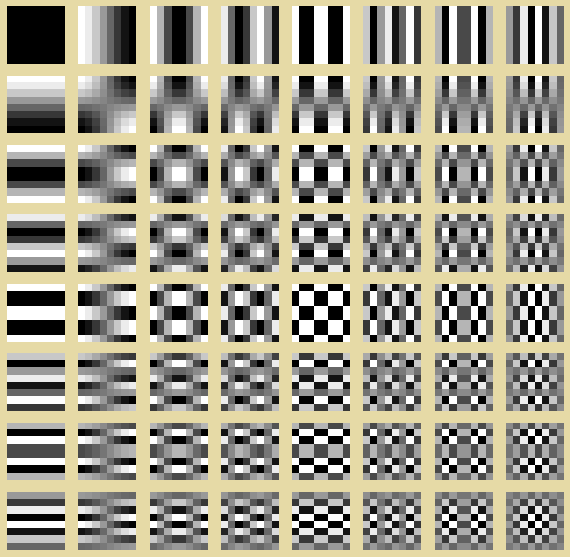

In [5]:
fig = plt.figure(1,figsize=(10,10))
fig.patch.set_facecolor('xkcd:beige')
idx = 1
for i in range(8):
    for j in range(8):
        X = np.zeros((8,8))
        X[i,j] = 1
        xh = IDCT_2D(X)
        
        plt.subplot(8,8,idx)        
        plt.imshow(xh, cmap='gray')        
        plt.axis('off')
        
        idx += 1
plt.imshow(xh, cmap='gray')   

### 3. Apply 2D-DCT on a 128x128 image

#### 3.1 read image

image size: (128, 128)
original type: uint8
after conversion type: float32


Text(0.5, 1.0, 'original 128x128 grayscale image')

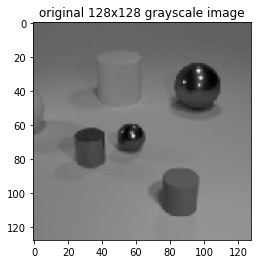

In [6]:
img = cv2.imread('CLEVR_sample.png', cv2.IMREAD_GRAYSCALE)
print('image size:', img.shape)
print('original type:', img.dtype)
img = np.float32(img)  # float conversion/scale
print('after conversion type:', img.dtype)
plt.imshow(img, cmap='gray')
plt.title("original 128x128 grayscale image")

#### 3.2 perform blockwise 2D-DCT on 8x8 patches 

Text(0.5, 1.0, '8x8 DCTs of the image')

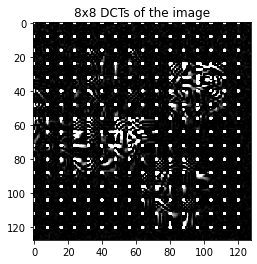

In [7]:
dct_img = np.zeros_like(img)
# Do 8x8 DCT on image (in-place)
for i in range(0, dct_img.shape[0], 8):
    for j in range(0, dct_img.shape[1], 8):
        dct_img[i:(i+8),j:(j+8)] = DCT_2D( img[i:(i+8),j:(j+8)] )
plt.figure()
plt.imshow(dct_img, cmap='gray', vmax=np.max(dct_img)*0.01,vmin=0)
plt.title("8x8 DCTs of the image")

### 4. Convert DCT coefficients back to image

Text(0.5, 1.0, '8x8 Inverse DCTs of the image')

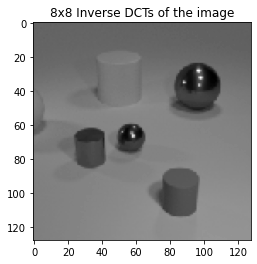

In [8]:
inverse_dct_img = np.zeros_like(dct_img)
for i in range(0, dct_img.shape[0], 8):
    for j in range(0, dct_img.shape[1], 8):
        inverse_dct_img[i:(i+8),j:(j+8)] = IDCT_2D(dct_img[i:(i+8),j:(j+8)] )
plt.figure()
plt.imshow(inverse_dct_img, cmap='gray')
plt.title( "8x8 Inverse DCTs of the image")

### 5.1. Threshold DCT coefficients

Text(0.5, 1.0, 'Thresholded 8x8 DCTs of the image')

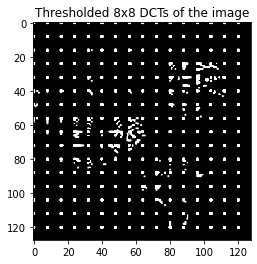

In [9]:
# Threshold
threshold = 0.012
dct_thresh = dct_img * (abs(dct_img) > (threshold*np.max(dct_img)))
plt.figure()
plt.imshow(dct_thresh, cmap='gray', vmax=np.max(dct_thresh)*0.01,vmin=0)
plt.title("Thresholded 8x8 DCTs of the image")

### 5.2 Compare DCT compressed image with original

Text(0.5, 1.0, 'Comparison between original and DCT compressed images')

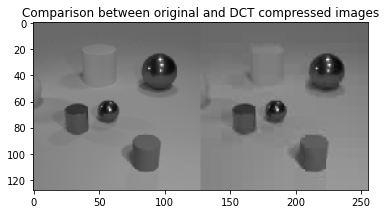

In [10]:
inverse_dct_thres_img = np.zeros_like(dct_thresh)
for i in range(0, dct_thresh.shape[0], 8):
    for j in range(0, dct_thresh.shape[1], 8):
        inverse_dct_thres_img[i:(i+8),j:(j+8)] = IDCT_2D(dct_thresh[i:(i+8),j:(j+8)] )
plt.figure()
plt.imshow(inverse_dct_thres_img, cmap='gray')
plt.imshow(np.hstack((img, inverse_dct_thres_img)),cmap='gray')
plt.title("Comparison between original and DCT compressed images" )

### 6. Take home exercise
- Calculate how many coefficients have been saved with DCT compression.
- Calculate image distortion in terms of Mean Squared Error (MSE).